# Website A/B Testing for Conversion Optimization

## **Problem:**

An e-commerce startup wants to know if a new checkout funnel (B) outperforms the old one (A).

### **Steps:**
1. Simulate click‐through data (visits vs. purchases) for A and B.  
2. Calculate conversion rates and 95% confidence intervals.  
3. Plot conversion rates with error bars.  
4. Perform a two‐proportion z‐test to see if B beats A.
5. Real-Time Monitoring & Sequential Testing


In [ ]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from statsmodels.stats.proportion import proportions_ztest

In [ ]:
np.random.seed(42)

In [ ]:
# Assume 10,000 visitors each
n_A, p_A = 10_000, 0.10   # Variant A: 10% true conversion
n_B, p_B = 10_000, 0.12   # Variant B: 12% true conversion

In [ ]:
# Simulate number of purchases
success_A = np.random.binomial(n_A, p_A)
success_B = np.random.binomial(n_B, p_B)

In [ ]:
print(success_A)
print(success_B)

973
1134


In [ ]:
def proportion_ci(successes, n, alpha=0.05):
    p_hat = successes / n
    z = stats.norm.ppf(1 - alpha/2)
    se = np.sqrt(p_hat * (1 - p_hat) / n)
    return p_hat, p_hat - z*se, p_hat + z*se

In [ ]:
p_A_hat, ci_low_A, ci_high_A = proportion_ci(success_A, n_A)
p_B_hat, ci_low_B, ci_high_B = proportion_ci(success_B, n_B)

In [ ]:
results = pd.DataFrame({
    'Variant':       ['A', 'B'],
    'Visitors':      [n_A, n_B],
    'Conversions':   [success_A, success_B],
    'CR (p̂)':       [p_A_hat, p_B_hat],
    'CI Lower (95%)':[ci_low_A, ci_low_B],
    'CI Upper (95%)':[ci_high_A, ci_high_B],
})
print(results)

  Variant  Visitors  Conversions  CR (p̂)  CI Lower (95%)  CI Upper (95%)
0       A     10000          973   0.0973        0.091491        0.103109
1       B     10000         1134   0.1134        0.107185        0.119615


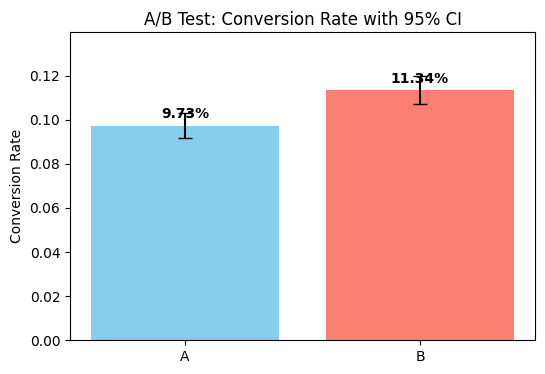

In [ ]:
# 3. Plot Conversion Rates with Error Bars
plt.figure(figsize=(6,4))
bars = plt.bar(
    results['Variant'],
    results['CR (p̂)'],
    yerr=[
        results['CR (p̂)'] - results['CI Lower (95%)'],
        results['CI Upper (95%)'] - results['CR (p̂)']
    ],
    capsize=5,
    color=['skyblue','salmon']
)
# Add numbers on top
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height + 0.002,
        f'{height:.2%}',  # format as percentage
        ha='center',
        va='bottom',
        fontsize=10,
        fontweight='bold'
    )

plt.ylabel('Conversion Rate')
plt.title('A/B Test: Conversion Rate with 95% CI')
plt.ylim(0, max(results['CI Upper (95%)']) + 0.02)
plt.show()

In [ ]:
# 4. Two-Proportion z-Test

# Test H0: p_B ≤ p_A  vs  H1: p_B > p_A
count = np.array([success_B, success_A])
nobs  = np.array([n_B, n_A])

z_stat, p_value = proportions_ztest(count, nobs, alternative='larger')
print(f"Z‐statistic: {z_stat:.3f}")
print(f"P‐value:     {p_value:.3f}")

if p_value < 0.05:
    print("→ Reject H0: Variant B has a significantly higher conversion rate.")
else:
    print("→ Fail to reject H0: No significant lift from B over A.")

Z‐statistic: 3.708
P‐value:     0.000
→ Reject H0: Variant B has a significantly higher conversion rate.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time
from statsmodels.stats.proportion import proportions_ztest
from IPython.display import clear_output

# Use the same true rates from above
true_p_A, true_p_B = 0.10, 0.12
batch_size = 100       # visitors per batch per variant
n_batches  = 60        # simulate 60 time steps (e.g. minutes)

# Initialize counters
n_visits_A = n_visits_B = 0
n_succ_A   = n_succ_B   = 0

# Lists to store metrics for plotting
batches   = []
p_values  = []
lifts     = []


Batch 60/60
  Variant A: 12000 visits, 1202 buys → CR = 10.017%
  Variant B: 12000 visits, 1419 buys → CR = 11.825%
  Observed lift: 1.808%
  z-stat = 4.49, p-value = 0.0000
  → Significant lift detected (p<0.05).


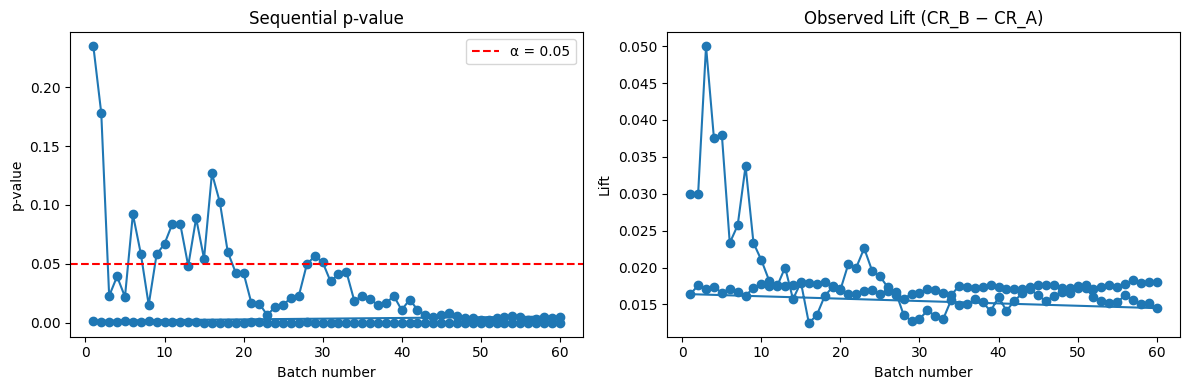

In [ ]:
for batch in range(1, n_batches+1):
    # Simulate one batch of visitors
    new_A = np.random.binomial(batch_size, true_p_A)
    new_B = np.random.binomial(batch_size, true_p_B)

    # Update totals
    n_visits_A += batch_size
    n_visits_B += batch_size
    n_succ_A   += new_A
    n_succ_B   += new_B

    # Compute current conversion rates
    cr_A = n_succ_A / n_visits_A
    cr_B = n_succ_B / n_visits_B
    lift = cr_B - cr_A

    # Two-proportion z-test (one-sided: B > A)
    count = np.array([n_succ_B, n_succ_A])
    nobs  = np.array([n_visits_B, n_visits_A])
    z_stat, p_val = proportions_ztest(count, nobs, alternative='larger')

    # Record for plotting
    batches.append(batch)
    p_values.append(p_val)
    lifts.append(lift)

    # Clear previous output and print current stats
    clear_output(wait=True)
    print(f"Batch {batch}/{n_batches}")
    print(f"  Variant A: {n_visits_A} visits, {n_succ_A} buys → CR = {cr_A:.3%}")
    print(f"  Variant B: {n_visits_B} visits, {n_succ_B} buys → CR = {cr_B:.3%}")
    print(f"  Observed lift: {lift:.3%}")
    print(f"  z-stat = {z_stat:.2f}, p-value = {p_val:.4f}")
    if p_val < 0.05:
        print("  → Significant lift detected (p<0.05).")
    else:
        print("  → No significant lift yet.")

    # Plot p-value and lift over batches
    fig, axes = plt.subplots(1, 2, figsize=(12,4))
    axes[0].plot(batches, p_values, '-o')
    axes[0].axhline(0.05, color='red', linestyle='--', label='α = 0.05')
    axes[0].set_title('Sequential p-value')
    axes[0].set_xlabel('Batch number')
    axes[0].set_ylabel('p-value')
    axes[0].legend()

    axes[1].plot(batches, lifts, '-o')
    axes[1].set_title('Observed Lift (CR_B − CR_A)')
    axes[1].set_xlabel('Batch number')
    axes[1].set_ylabel('Lift')

    plt.tight_layout()
    plt.show()

  #   # Pause briefly to simulate real time
  #   time.sleep(0.9)